## Install required dependencies

In [1]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scipy
!pip install scikit-learn
!pip install torch
!pip install tqdm
# !pip install git+https://github.com/pratikrathore8/fast_krr.git

In [1]:
from fast_krr.opts._utils import general

ModuleNotFoundError: No module named 'fast_krr.opts._utils'

## Import required libraries

In [2]:
import matplotlib.pyplot as plt
import torch
from tqdm import trange

from fast_krr.models import FullKRR
from fast_krr.opts import ASkotchV2

from utils import load_data

## Load the uracil dataset

In [3]:
data_config ={
    "tr": "md17_uracil.npz",
    "loading": "npz",
    "split": 0.8,
    "task": "regression",
}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
X, Xtst, y, ytst = load_data(dataset="uracil", data_config=data_config, 
                             remove_label_means=True, seed=0, device=device)

## Initialize the model

In [6]:
n = X.shape[0]
lambd = 1e-9 * X.shape[0]
model = FullKRR(X, y, Xtst, ytst, kernel_params={"type": "matern", "nu": 5 / 2, "sigma": X.shape[1] ** 0.5},
                 Ktr_needed=True, lambd=lambd, task="regression", 
                 w0=torch.zeros(n, device=device), device=device)

## Initialize the optimizer

In [7]:
opt = ASkotchV2(model=model, block_sz=n // 100, precond_params={"type": "nystrom", "r": 100, "rho": "damped"})

## Train the model using the optimizer

In [8]:
max_iters = 5000
log_freq = 20
metrics = []

metrics.append((0, model.compute_metrics(v=opt.model.w, log_test_only=False)))

# Do this with tqdm
for i in trange(1, max_iters + 1, desc="Optimization progress"):
    opt.step()

    if i % log_freq == 0:
        metrics.append((i , model.compute_metrics(v=opt.model.w, log_test_only=False)))

Optimization progress: 100%|██████████| 5000/5000 [07:41<00:00, 10.84it/s]


## Plot the results

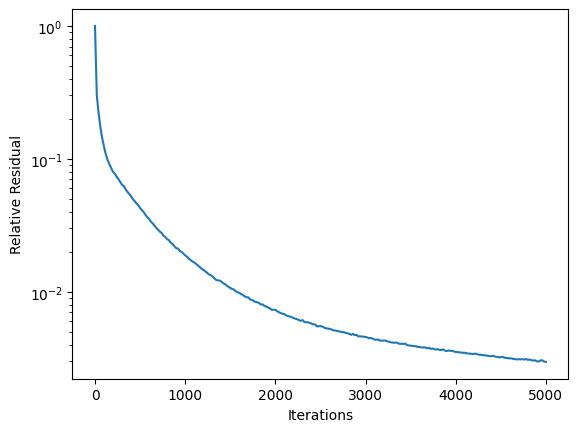

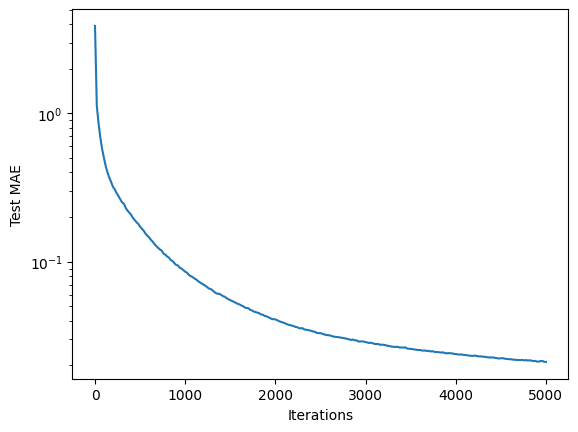

In [9]:
rel_residuals = [m["rel_residual"].cpu() for _, m in metrics]
test_mae = [m["test_mae"] for _, m in metrics]
x_vals = [i for i, _ in metrics]

plt.figure()
plt.semilogy(x_vals, rel_residuals)
plt.ylabel("Relative Residual")
plt.xlabel("Iterations")
plt.show()

plt.figure()
plt.semilogy(x_vals, test_mae)
plt.ylabel("Test MAE")
plt.xlabel("Iterations")
plt.show()